# Previsão de Quantidade Diária - Versão Simplificada
 
Este notebook implementa um pipeline simples para prever a quantidade de vendas diária de produtos.

**Passos:**
1. Carregar e agregar dados diários.
2. Tratar datas faltantes e preencher zeros.
3. Criar features simples: dia da semana, mês, ano, feriado.
4. Dividir em treino, validação e teste.
5. Escalonar dados com base no treino.
6. Criar sequências de 30 dias para alimentar o LSTM.
7. Treinar um modelo simples LSTM para prever a quantidade do dia seguinte.
8. Avaliar no conjunto de validação e teste.

In [133]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import itertools

def invert_scaling(scaled_values, scaler, feature_cols):
    temp = np.zeros((len(scaled_values), len(feature_cols)))
    temp[:, 0] = scaled_values
    inv = scaler.inverse_transform(temp)
    return inv[:,0]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # alvo na coluna 0
    return np.array(X), np.array(y)

def run_experiment(X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_cols,
                   seq_length=60, batch_size=32, lstm_units_1=128, lstm_units_2=64,
                   dropout=0.2, learning_rate=0.0005, epochs=100):
    model = Sequential()
    model.add(LSTM(lstm_units_1, return_sequences=True, dropout=dropout, input_shape=(seq_length, len(feature_cols))))
    model.add(LSTM(lstm_units_2, return_sequences=False, dropout=dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_val, y_val),
              callbacks=[early_stop],
              verbose=0)

    val_preds = model.predict(X_val, verbose=0)
    val_preds_inverted = invert_scaling(val_preds.flatten(), scaler, feature_cols)
    y_val_inverted = invert_scaling(y_val, scaler, feature_cols)
    mse_val = mean_squared_error(y_val_inverted, val_preds_inverted)
    mae_val = mean_absolute_error(y_val_inverted, val_preds_inverted)

    if X_test.shape[0] > 0:
        test_preds = model.predict(X_test, verbose=0)
        test_preds_inverted = invert_scaling(test_preds.flatten(), scaler, feature_cols)
        y_test_inverted = invert_scaling(y_test, scaler, feature_cols)
        mse_test = mean_squared_error(y_test_inverted, test_preds_inverted)
        mae_test = mean_absolute_error(y_test_inverted, test_preds_inverted)
    else:
        mse_test = np.inf
        mae_test = np.inf

    return mse_val, mae_val, mse_test, mae_test, model


In [134]:
# Caminho para o arquivo CSV
csv_path = '../data/dados_transacao_26173.csv'

# Carrega os dados
df = pd.read_csv(csv_path, parse_dates=['Data'])

# Agregar por dia
daily_agg = df.groupby('Data').agg({
    'Quantidade': 'sum',
    'ValorTotal': 'sum',
    'TotalPedido': 'sum',
    'TotalCusto': 'sum',
    'Desconto': 'sum',
    'Acrescimo': 'sum',
    'VendaCancelada': 'sum',
    'ItemCancelado': 'sum',
    'QuantDevolvida': 'sum',
    'EmPromocao': 'sum'
}).reset_index()

# Criar ValorMedioUnitario e outras métricas
daily_agg['ValorMedioUnitario'] = np.where(daily_agg['Quantidade']>0, daily_agg['ValorTotal']/daily_agg['Quantidade'], 0)
daily_agg['DescontoMedio'] = np.where(daily_agg['Quantidade']>0, daily_agg['Desconto']/daily_agg['Quantidade'], 0)
daily_agg['AcrescimoMedio'] = np.where(daily_agg['Quantidade']>0, daily_agg['Acrescimo']/daily_agg['Quantidade'], 0)
daily_agg['MargemMediaItem'] = np.where(daily_agg['Quantidade']>0, (daily_agg['ValorTotal'] - daily_agg['TotalCusto'])/daily_agg['Quantidade'], 0)
daily_agg['TaxaCancelamento'] = np.where(daily_agg['Quantidade']>0, daily_agg['ItemCancelado']/daily_agg['Quantidade'], 0)
daily_agg['TaxaPromocao'] = np.where(daily_agg['Quantidade']>0, daily_agg['EmPromocao']/daily_agg['Quantidade'], 0)

if 'VesperaDeFeriado' in df.columns:
    vespera_agg = df.groupby('Data')['VesperaDeFeriado'].max().reset_index()
    daily_agg = pd.merge(daily_agg, vespera_agg, on='Data', how='left')
    daily_agg['VesperaDeFeriado'] = daily_agg['VesperaDeFeriado'].fillna(0).astype(int)
else:
    daily_agg['VesperaDeFeriado'] = 0

# Garantir datas contínuas
all_dates = pd.date_range(start=daily_agg['Data'].min(), end=daily_agg['Data'].max(), freq='D')
daily_df = pd.DataFrame({'Data': all_dates})
daily_df = pd.merge(daily_df, daily_agg, on='Data', how='left')

# Preencher NaNs
cols_to_fill_zero = ['Quantidade','ValorTotal','TotalPedido','TotalCusto','Desconto','Acrescimo','VendaCancelada','ItemCancelado','QuantDevolvida','EmPromocao']
daily_df[cols_to_fill_zero] = daily_df[cols_to_fill_zero].fillna(0)
cols_to_fill_zero_2 = ['ValorMedioUnitario', 'DescontoMedio','AcrescimoMedio','MargemMediaItem','TaxaCancelamento','TaxaPromocao','VesperaDeFeriado']
daily_df[cols_to_fill_zero_2] = daily_df[cols_to_fill_zero_2].fillna(0)

# Marcar feriados
br_holidays = holidays.Brazil()
daily_df['Feriado'] = daily_df['Data'].isin(br_holidays).astype(int)

# Features temporais
daily_df['Ano'] = daily_df['Data'].dt.year
daily_df['Mes'] = daily_df['Data'].dt.month
daily_df['Dia'] = daily_df['Data'].dt.day
daily_df['DiaDaSemana'] = daily_df['Data'].dt.dayofweek

daily_df['DiaDaSemana_sin'] = np.sin(2 * np.pi * daily_df['DiaDaSemana']/7)
daily_df['DiaDaSemana_cos'] = np.cos(2 * np.pi * daily_df['DiaDaSemana']/7)
daily_df['Mes_sin'] = np.sin(2 * np.pi * (daily_df['Mes']-1)/12)
daily_df['Mes_cos'] = np.cos(2 * np.pi * (daily_df['Mes']-1)/12)

# Médias móveis do ValorMedioUnitario
daily_df['ValorMedioUnitario_7d_mean'] = daily_df['ValorMedioUnitario'].rolling(window=7, min_periods=1).mean()
daily_df['ValorMedioUnitario_14d_mean'] = daily_df['ValorMedioUnitario'].rolling(window=14, min_periods=1).mean()
daily_df.fillna(method='bfill', inplace=True)

# Weekend e PrimeiraSemanaDoMes
daily_df['Weekend'] = daily_df['DiaDaSemana'].apply(lambda x: 1 if x >= 5 else 0)
daily_df['PrimeiraSemanaDoMes'] = daily_df['Dia'].apply(lambda x: 1 if x <= 7 else 0)

# Definição das features e target (ValorMedioUnitario como target na posição 0)
feature_cols = [
    'ValorMedioUnitario',
    'Feriado',
    'DiaDaSemana_sin', 'DiaDaSemana_cos',
    'Mes_sin', 'Mes_cos',
    'ValorMedioUnitario_7d_mean', 'ValorMedioUnitario_14d_mean',
    'Weekend',
    'PrimeiraSemanaDoMes',
    'DescontoMedio', 'AcrescimoMedio', 'MargemMediaItem',
    'TaxaCancelamento', 'TaxaPromocao',
    'VesperaDeFeriado'
]

# Divisão temporal
train_end = pd.to_datetime('2022-12-31')
val_end = pd.to_datetime('2023-12-31')
test_start = pd.to_datetime('2024-01-01')
test_end = pd.to_datetime('2024-03-30')

train_df = daily_df[daily_df['Data'] <= train_end]
val_df = daily_df[(daily_df['Data'] > train_end) & (daily_df['Data'] <= val_end)]
test_df = daily_df[(daily_df['Data'] >= test_start) & (daily_df['Data'] <= test_end)]

print("Tamanho Treino:", len(train_df))
print("Tamanho Validação:", len(val_df))
print("Tamanho Teste:", len(test_df))

# Escalonamento
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])
train_scaled = scaler.transform(train_df[feature_cols])
val_scaled = scaler.transform(val_df[feature_cols])
test_scaled = scaler.transform(test_df[feature_cols])


Tamanho Treino: 1460
Tamanho Validação: 365
Tamanho Teste: 90


/tmp/ipykernel_41480/3255488972.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_df.fillna(method='bfill', inplace=True)


In [135]:
# Definição dos hiperparâmetros a testar
seq_lengths = [30, 60]
batch_sizes = [8, 16, 32, 64]
lstm_units_1_list = [64, 128]
lstm_units_2_list = [32, 64]
dropouts = [0.0, 0.2, 0.4]
learning_rates = [0.001, 0.004, 0.0005]
epoch_list = [100, 200, 300, 500]

best_score = np.inf
best_params = None
best_model = None

# Loop pelos hiperparâmetros
for seq_length in seq_lengths:
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_val, y_val = create_sequences(val_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Caso não haja dados suficientes no teste para esse seq_length, continuar
    if X_test.shape[0] == 0:
        continue

    for batch_size in batch_sizes:
        for lstm_units_1 in lstm_units_1_list:
            for lstm_units_2 in lstm_units_2_list:
                for dropout in dropouts:
                    for lr in learning_rates:
                        for ep in epoch_list:
                            mse_val, mae_val, mse_test, mae_test, model = run_experiment(
                                X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_cols,
                                seq_length=seq_length,
                                batch_size=batch_size,
                                lstm_units_1=lstm_units_1,
                                lstm_units_2=lstm_units_2,
                                dropout=dropout,
                                learning_rate=lr,
                                epochs=ep
                            )

                            if mse_test < best_score:
                                best_score = mse_test
                                best_params = {
                                    'seq_length': seq_length,
                                    'batch_size': batch_size,
                                    'lstm_units_1': lstm_units_1,
                                    'lstm_units_2': lstm_units_2,
                                    'dropout': dropout,
                                    'learning_rate': lr,
                                    'epochs': ep,
                                    'mse_test': mse_test,
                                    'mae_test': mae_test
                                }
                                best_model = model

print("Melhor resultado encontrado:")
print(best_params)

# Salvar o melhor modelo
best_model.save("melhor_modelo.h5")
print("Melhor modelo salvo em 'melhor_modelo.h5'")


/home/jociano/Projects/PromoPredictor/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jociano/Projects/PromoPredictor/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jociano/Projects/PromoPredictor/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jociano/Projects/PromoPredictor/.venv

Melhor resultado encontrado:
{'seq_length': 60, 'batch_size': 8, 'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.2, 'learning_rate': 0.004, 'epochs': 500, 'mse_test': 0.3332879041762297, 'mae_test': 0.4972561583862634}
Melhor modelo salvo em 'melhor_modelo.h5'


Melhor MSE Teste: 0.3332879041762297 MAE Teste: 0.4972561583862634


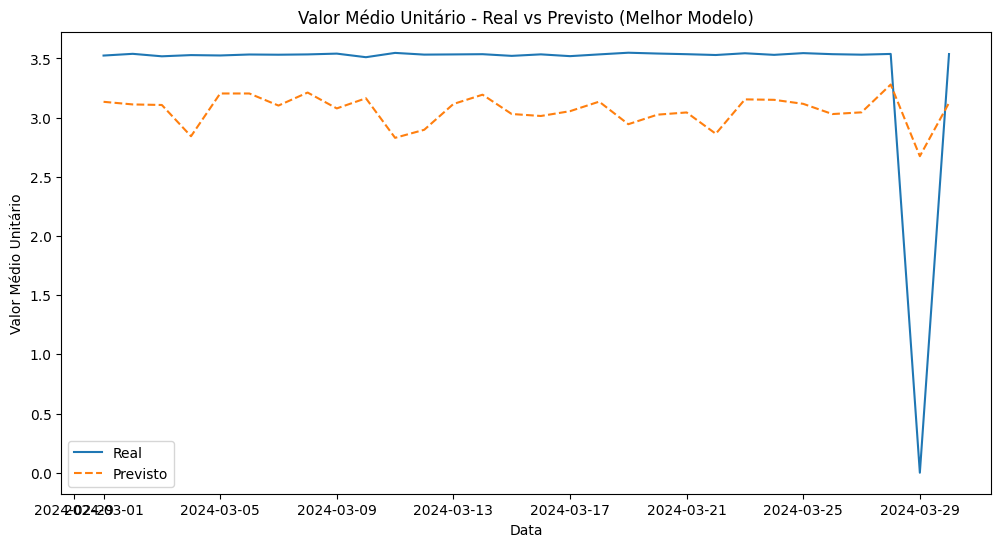

In [136]:
# Como já temos best_model, best_params, podemos exibir as métricas
print("Melhor MSE Teste:", best_params['mse_test'], "MAE Teste:", best_params['mae_test'])

# Se desejar, é possível também refazer a predição do melhor modelo e plotar novamente
# usando o seq_length do melhor_params e test_df

best_seq_length = best_params['seq_length']
X_test_best, y_test_best = create_sequences(test_scaled, best_seq_length)
test_preds_best = best_model.predict(X_test_best, verbose=0)
test_preds_inverted_best = invert_scaling(test_preds_best.flatten(), scaler, feature_cols)
y_test_inverted_best = invert_scaling(y_test_best, scaler, feature_cols)

test_dates_best = test_df['Data'].iloc[best_seq_length:].values

plt.figure(figsize=(12,6))
plt.plot(test_dates_best, y_test_inverted_best, label='Real')
plt.plot(test_dates_best, test_preds_inverted_best, label='Previsto', linestyle='--')
plt.title('Valor Médio Unitário - Real vs Previsto (Melhor Modelo)')
plt.xlabel('Data')
plt.ylabel('Valor Médio Unitário')
plt.legend()
plt.show()
